# Three-particle potentials

In this notebook we'll explore the Stillinger-Weber three-particle potential applied to a system of silicon (Si) atoms.
The Stillinger-Weber potential is given by a two-particle potential similar to Lennard-Jones and a three-particle potential.
\begin{align}
    U(r)
    = \sum_{ij} U(r_{ij})
    + \sum_{ijk} U(r_{ij}, r_{ik}, \theta_{ijk}).
\end{align}
The two-particle potential is given by
\begin{align}
    U(r_{ij})
    = A \epsilon\left[
        B \left(
            \frac{\sigma}{r_{ij}}
        \right)^{p}
        - \left(
            \frac{\sigma}{r_{ij}}
        \right)^{q}
    \right]
    \exp\left(
        \frac{\sigma}{r_{ij} - a\sigma}
    \right),
\end{align}
where $A$, $B$, $\epsilon$, $\sigma$, $p$, $q$ and $a$ are coefficients that can be adjusted depending on the system we are perusing.
The three-particle potential has the form
\begin{align}
    U(r_{ij}, r_{ik}, \theta_{ijk})
    = \lambda \epsilon \left[
        \cos(\theta_{ijk})
        - \cos(\theta_{0})
    \right]^2
    \exp\left(
        \frac{\gamma\sigma}{r_{ij} - a\sigma}
    \right)
    \exp\left(
        \frac{\gamma\sigma}{r_{ik} - a\sigma}
    \right),
\end{align}
where we've introduced the new parameters $\lambda$ and $\gamma$.
Note that we've simplified the potentials as we've removed the indices that can be associated with every coefficient to specify different types of interactions between atoms.
Below we use the given parameter file.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model

sns.set(color_codes=True)

In [2]:
%%writefile scripts/Si.sw
# DATE: 2007-06-11 CONTRIBUTOR: Aidan Thompson, athomps@sandia.gov
# CITATION: Stillinger and Weber,  Phys Rev B, 31, 5262, (1985)
# Stillinger-Weber parameters for various elements and mixtures
# multiple entries can be added to this file,
# LAMMPS reads the ones it needs
# these entries are in LAMMPS "metal" units:
#   epsilon = eV; sigma = Angstroms
#   other quantities are unitless
# format of a single entry (one or more lines):
#   element 1, element 2, element 3,
#   epsilon, sigma, a, lambda, gamma, costheta0, A, B, p, q, tol
# Here are the original parameters in metal units, for Silicon from:
#
# Stillinger and Weber,  Phys. Rev. B, v. 31, p. 5262, (1985)
#

Si # element 1
Si # element 2
Si # element 3
2.1683 # epsilon
2.0951 # sigma
1.80 # a
21.0 # lambda
1.20 # gamma
-0.333333333333 # cos(theta_0)
7.049556277 # A
0.6022245584 # B
4.0 # p
0.0 # q
0.0 # tol

Overwriting scripts/Si.sw


In the Lennard-Jones-scripts we only specify $\epsilon$, $\sigma$ and $r_c$ (cut-off).
Furthermore, we see that for $A = 4$, $B = 1$, $p = 12$, and $q = 6$ we almost recover the Lennard-Jones potential in the two-particle potential if we remove the exponential cut-off function.
With $p = 4$ we lower the repulsive effect of the two-particle potential and by setting $q = 0$ we use a fixed attractive force between the particles.

In [3]:
%%writefile scripts/si.in

units           metal
atom_style      atomic
atom_modify     map array
boundary        p p p
atom_modify     sort 0 0.0

# temperature
#variable T equal 1200.0

# diamond unit cell
variable myL equal 10
variable myscale equal 1.3

variable a equal 5.431*${myscale}
lattice         custom $a               &
                a1 1.0 0.0 0.0          &
                a2 0.0 1.0 0.0          &
                a3 0.0 0.0 1.0          &
                basis 0.0 0.0 0.0       &
                basis 0.0 0.5 0.5       &
                basis 0.5 0.0 0.5       &
                basis 0.5 0.5 0.0       &
                basis 0.25 0.25 0.25    &
                basis 0.25 0.75 0.75    &
                basis 0.75 0.25 0.75    &
                basis 0.75 0.75 0.25

region          myreg block     0 ${myL} &
                                0 ${myL} &
                                0 ${myL}

create_box      1 myreg
create_atoms    1 region myreg

mass            1       28.06

group Si type 1

velocity all create ${T} 5287286 mom yes rot yes dist gaussian

pair_style      sw
pair_coeff * * scripts/Si.sw Si

neighbor        1.0 bin
neigh_modify    every 1 delay 10 check yes

timestep        1.0e-3
#fix             1 all nve
# Try using fix npt
fix             1 all nvt temp ${T} ${T} 0.05

# Run simulation
thermo          10
#dump 1 all custom 10 dat/si.lammpstrj id type x y z vx vy vz
run             5000


reset_timestep 0
variable time equal dt*step
compute msd all msd
thermo_style custom step v_time temp ke pe etotal press c_msd[4]

log dat/si_${T}.log

run 10000

Overwriting scripts/si.in


In [10]:
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1200 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1300 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1400 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1500 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1600 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1700 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1800 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 1900 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2000 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2100 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2200 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2400 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2500 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2600 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2700 -in scripts/si.in
!export OMP_NUM_THREADS=4 && \
    mpirun -np 2 lmp -var T 2800 -in scripts/si.in

LAMMPS (4 Jan 2019)
Lattice spacing in x,y,z = 7.0603 7.0603 7.0603
Created orthogonal box = (0 0 0) to (70.603 70.603 70.603)
  1 by 1 by 2 MPI processor grid
Created 8000 atoms
  Time spent = 0.001004 secs
8000 atoms in group Si
Reading potential file scripts/Si.sw with DATE: 2007-06-11
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 4.77118
  ghost atom cutoff = 4.77118
  binsize = 2.38559, bins = 30 30 30
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair sw, perpetual
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.226 | 3.226 | 3.226 Mbytes
Step Temp E_pair E_mol TotEng Press 
       0         2100   -11274.993            0   -9103.6944   -197904.52 
     

     970     2057.731   -25014.797            0   -22887.202   -13505.177 
     980    2074.9089   -25043.277            0   -22897.921   -14053.613 
     990    2080.8409   -25058.052            0   -22906.562   -14086.218 
    1000    2055.3344   -25038.374            0   -22913.257   -13507.125 
    1010    2069.2432   -25056.171            0   -22916.673    -13180.51 
    1020    2102.8129   -25091.999            0   -22917.792    -13177.24 
    1030    2099.1029   -25089.184            0   -22918.813    -13190.19 
    1040    2085.4059   -25075.826            0   -22919.617   -13403.385 
    1050    2117.6915   -25109.292            0   -22919.701   -13925.614 
    1060    2139.8138   -25133.613            0   -22921.149   -14394.307 
    1070    2123.5915    -25121.24            0   -22925.549   -14278.995 
    1080    2125.8624   -25130.229            0   -22932.189   -13814.936 
    1090    2123.3222   -25136.295            0   -22940.882   -13163.575 
    1100    2125.5206   -

    2070    2088.9583   -26222.205            0   -24062.323   -8553.2943 
    2080     2081.215   -26223.405            0   -24071.529   -8914.2728 
    2090    2091.2538   -26241.697            0   -24079.441   -9065.6096 
    2100    2080.9856   -26238.012            0   -24086.373   -9085.5954 
    2110    2081.4343   -26243.923            0    -24091.82   -8966.4899 
    2120    2101.4236   -26268.754            0   -24095.983   -9111.3281 
    2130    2101.2408    -26272.67            0   -24100.088   -9256.6188 
    2140    2087.7377   -26262.773            0   -24104.152   -9523.9302 
    2150    2087.5739   -26265.801            0    -24107.35   -9394.4941 
    2160    2094.5811   -26275.276            0    -24109.58   -9328.0226 
    2170    2099.8983   -26282.528            0   -24111.334   -9263.3986 
    2180     2101.789    -26286.22            0   -24113.072   -8988.0253 
    2190    2095.9734   -26282.025            0   -24114.889   -8768.7023 
    2200    2100.5414    

    3170    2099.1246   -26896.431            0   -24726.037   -7476.1072 
    3180    2099.3054   -26899.792            0   -24729.211    -7225.114 
    3190     2116.023   -26920.364            0   -24732.498   -7551.8938 
    3200    2141.8395   -26951.855            0   -24737.296   -7869.0349 
    3210    2130.2366     -26947.8            0   -24745.238   -7468.2382 
    3220    2111.0889   -26938.363            0   -24755.598   -6559.8509 
    3230    2108.1808   -26946.685            0   -24766.928   -5772.2424 
    3240    2123.5321   -26974.671            0    -24779.04   -5649.1591 
    3250     2144.314   -27010.477            0   -24793.359   -6335.0165 
    3260     2114.278   -26996.757            0   -24810.695   -6705.4104 
    3270    2090.6132   -26990.528            0   -24828.934   -7247.2012 
    3280     2074.065   -26990.624            0    -24846.14   -7643.7401 
    3290    2056.9887   -26987.682            0   -24860.854   -7682.6157 
    3300    2070.6685   -

    4270    2069.4602   -27423.038            0   -25283.315   -6750.4873 
    4280    2081.8382   -27428.339            0   -25275.818   -6809.9967 
    4290    2096.7623   -27434.647            0   -25266.696   -7257.1225 
    4300    2113.1385   -27442.216            0   -25257.333   -7324.1053 
    4310    2120.2484   -27441.154            0   -25248.919   -7140.8283 
    4320    2113.6146   -27427.491            0   -25242.115   -6684.5115 
    4330    2099.9926    -27407.69            0   -25236.398   -6510.5359 
    4340    2105.5415   -27407.955            0   -25230.926   -6398.8197 
    4350    2105.4575   -27402.699            0   -25225.758   -6171.4963 
    4360    2122.1823   -27415.464            0    -25221.23   -6269.7163 
    4370    2128.1705   -27418.803            0   -25218.377   -5994.5339 
    4380     2127.195   -27417.338            0    -25217.92   -5385.4741 
    4390     2115.917   -27407.327            0   -25219.571   -4920.3501 
    4400    2120.0433   -

     140         0.14    2119.0071    2190.9514   -27642.448   -25451.496   -3735.5373    0.9948343 
     150         0.15    2107.9435    2179.5122    -27632.71   -25453.198   -3915.3687     1.085859 
     160         0.16    2096.2791    2167.4517   -27623.039   -25455.588   -4195.3201    1.1778245 
     170         0.17     2080.679     2151.322   -27608.863   -25457.541   -4653.8374    1.2694763 
     180         0.18    2097.5256    2168.7405   -27627.003   -25458.262   -5302.3019    1.3596536 
     190         0.19    2101.9918    2173.3584   -27631.988    -25458.63   -5522.0208    1.4478432 
     200          0.2    2084.3525    2155.1203   -27614.122   -25459.001   -5331.3907    1.5342527 
     210         0.21    2068.9883    2139.2344   -27597.299   -25458.065   -5545.0774    1.6190353 
     220         0.22    2084.7823    2155.5646   -27610.443   -25454.878   -6125.4967    1.7021806 
     230         0.23    2102.3601    2173.7392    -27624.18    -25450.44    -6962.461    1

     960         0.96    2117.2052    2189.0883   -27823.691   -25634.603    -5718.443    9.4104811 
     970         0.97    2118.3915    2190.3149   -27831.436   -25641.121    -5272.619    9.5412608 
     980         0.98    2115.4137     2187.236   -27836.416    -25649.18   -4742.6404    9.6726145 
     990         0.99    2107.5566    2179.1122   -27837.499   -25658.387   -4466.7973    9.8011282 
    1000            1    2105.1174    2176.5901   -27844.862   -25668.271   -4684.2076    9.9260301 
    1010         1.01     2093.543    2164.6228   -27843.035   -25678.412    -5180.261    10.048515 
    1020         1.02    2086.2599    2157.0923   -27845.049   -25687.956   -5290.0023    10.170114 
    1030         1.03    2107.2225    2178.7667   -27875.399   -25696.632   -5109.5276    10.292148 
    1040         1.04    2117.7084    2189.6086    -27895.49   -25705.881   -4608.1292    10.415154 
    1050         1.05    2104.5768    2176.0312    -27892.34   -25716.309   -3820.2243    1

    1780         1.78    2141.8745    2214.5952   -28056.751   -25842.156   -2362.8946    20.657937 
    1790         1.79     2121.826     2193.866     -28040.4   -25846.534   -1882.6933    20.812209 
    1800          1.8    2106.8984    2178.4316   -28031.197   -25852.765   -2357.0165    20.965759 
    1810         1.81    2116.7701    2188.6385    -28048.46   -25859.822   -3482.1587    21.120025 
    1820         1.82    2113.5302    2185.2885   -28053.404   -25868.115   -4363.3991    21.274942 
    1830         1.83     2105.774     2177.269   -28054.713   -25877.444   -4672.7279    21.429976 
    1840         1.84    2103.7973    2175.2253   -28062.523   -25887.298   -4732.9502    21.585767 
    1850         1.85    2092.1029    2163.1337   -28060.402   -25897.268   -4652.9558    21.743214 
    1860         1.86    2089.7441    2160.6948   -28067.319   -25906.624   -4746.1046    21.901944 
    1870         1.87    2087.6546    2158.5344   -28073.641   -25915.107   -4546.1006    2

    2600          2.6    2122.5716     2194.637    -28222.09   -26027.453   -1208.6015    33.542418 
    2610         2.61    2106.1426    2177.6501   -28217.603   -26039.952    -1773.408    33.718857 
    2620         2.62    2083.1329    2153.8593   -28206.461   -26052.602   -2050.2879    33.890887 
    2630         2.63    2100.6576    2171.9789   -28236.187   -26064.208   -1911.4438    34.059401 
    2640         2.64    2099.0568    2170.3238   -28245.927   -26075.603    -997.1952    34.226286 
    2650         2.65    2086.7162    2157.5642   -28244.282   -26086.718   -531.73725    34.393101 
    2660         2.66    2091.3484    2162.3536     -28259.2   -26096.846    -1063.226    34.559355 
    2670         2.67    2082.9377    2153.6574   -28259.684   -26106.027     -1448.82    34.724943 
    2680         2.68    2086.6622    2157.5083   -28271.468    -26113.96   -2283.5558    34.888457 
    2690         2.69     2083.544    2154.2843   -28274.942   -26120.657   -2777.9566    3

    3420         3.42    2096.8663    2168.0589    -28343.17   -26175.111   -1956.1624     47.71505 
    3430         3.43    2117.4369    2189.3279   -28359.042   -26169.714   -1896.6062     47.88901 
    3440         3.44    2116.4549    2188.3126   -28353.774   -26165.462    -1529.828    48.060864 
    3450         3.45    2114.0633    2185.8397   -28348.504   -26162.665   -1389.8053    48.230234 
    3460         3.46    2101.3497    2172.6945   -28333.595     -26160.9   -1431.8615    48.399785 
    3470         3.47    2100.6249    2171.9451   -28331.319   -26159.374    -1587.772    48.573387 
    3480         3.48    2111.9462    2183.6508   -28341.649   -26157.998   -1786.2138    48.753458 
    3490         3.49    2105.9154    2177.4152   -28334.869   -26157.454   -1627.7221     48.93738 
    3500          3.5    2091.7072    2162.7246   -28320.014    -26157.29   -1550.6226    49.118459 
    3510         3.51    2107.6863    2179.2462   -28336.018   -26156.772   -2004.3353    4

    4240         4.24    2083.9142    2154.6671   -28418.655   -26263.988   -3147.1158    62.802354 
    4250         4.25     2097.155    2168.3574   -28431.158   -26262.801   -3003.5638    62.997656 
    4260         4.26    2086.1458    2156.9744   -28418.089   -26261.115   -2575.8901    63.191105 
    4270         4.27    2100.8813    2172.2102   -28430.747   -26258.537   -2292.9656    63.383623 
    4280         4.28    2126.8007    2199.0097   -28455.129   -26256.119   -2407.9988    63.577431 
    4290         4.29    2110.6156    2182.2751     -28437.8   -26255.525   -2098.1307    63.775048 
    4300          4.3    2092.1651    2163.1981   -28419.026   -26255.828     -1978.06    63.974218 
    4310         4.31    2105.2452    2176.7223   -28432.474   -26255.752    -2296.179     64.17359 
    4320         4.32    2118.4968    2190.4237   -28446.589   -26256.165   -2886.4264    64.371884 
    4330         4.33    2093.8535    2164.9438   -28422.637   -26257.694    -2763.674    6

    5060         5.06    2079.6273    2150.2346   -28535.701   -26385.467   -2894.3304    79.564213 
    5070         5.07    2084.9122     2155.699   -28544.798   -26389.099   -3323.0707    79.764437 
    5080         5.08    2080.7019    2151.3457   -28542.721   -26391.375   -3525.2055    79.968099 
    5090         5.09    2075.6043     2146.075   -28538.129   -26392.054   -3363.5443    80.172136 
    5100          5.1    2079.9137    2150.5307   -28541.416   -26390.886    -3133.408    80.373042 
    5110         5.11     2068.936    2139.1803   -28526.992   -26387.812      -2497.7    80.571169 
    5120         5.12    2088.6248    2159.5376   -28542.118    -26382.58   -2560.3163    80.772282 
    5130         5.13    2085.9986    2156.8222   -28532.878   -26376.055   -3053.5919    80.980375 
    5140         5.14    2085.9812    2156.8042   -28525.336   -26368.532   -3407.6239    81.194164 
    5150         5.15    2091.3935    2162.4003   -28522.296   -26359.895   -3429.7724    8

    5880         5.88    2089.5318    2160.4754   -28583.856    -26423.38   -2972.2372    96.526959 
    5890         5.89    2097.2239    2168.4287   -28594.581   -26426.153   -2493.8357    96.708798 
    5900          5.9    2108.3082    2179.8893   -28608.544   -26428.655   -1811.1374    96.889251 
    5910         5.91    2097.6863    2168.9067   -28600.505   -26431.599   -1819.2111    97.073094 
    5920         5.92    2103.3816    2174.7954   -28609.412   -26434.616   -2551.2923    97.256568 
    5930         5.93    2099.6659    2170.9535   -28608.726   -26437.772   -2746.6858    97.432906 
    5940         5.94     2088.198    2159.0963   -28599.995   -26440.899   -2350.3971    97.600204 
    5950         5.95    2077.3806    2147.9116   -28590.901   -26442.989   -1616.7082    97.765325 
    5960         5.96     2091.366    2162.3718   -28605.855   -26443.483   -1337.7788    97.935815 
    5970         5.97    2099.3401    2170.6167   -28613.869   -26443.252   -1630.2048    9

    6700          6.7    2088.4914    2159.3996   -28611.793   -26452.393   -4008.0425    111.27004 
    6710         6.71    2084.9712    2155.7599   -28610.151   -26454.391   -4296.4135    111.46535 
    6720         6.72    2095.8975    2167.0572   -28622.313   -26455.256   -4694.5885    111.66711 
    6730         6.73    2117.5646    2189.4599   -28645.394   -26455.934   -4862.0006      111.869 
    6740         6.74    2117.1325    2189.0132   -28646.892   -26457.879   -4311.0602    112.06741 
    6750         6.75    2094.7689    2165.8903   -28626.999   -26461.109   -3546.6226    112.26033 
    6760         6.76    2085.1068    2155.9001    -28619.89   -26463.989   -3200.6772    112.44858 
    6770         6.77    2107.8239    2179.3886   -28645.403   -26466.014   -3553.9244    112.63797 
    6780         6.78    2111.6098     2183.303   -28651.795   -26468.492   -3814.0102     112.8352 
    6790         6.79    2098.7866    2170.0444   -28641.911   -26471.867   -3680.4788    1

    7520         7.52    2095.4704    2166.6156   -28651.378   -26484.762   -1370.8121    127.16427 
    7530         7.53    2093.0294    2164.0917   -28647.832    -26483.74   -1631.9125    127.32267 
    7540         7.54    2120.5731    2192.5706   -28675.183   -26482.612   -2302.1698    127.48648 
    7550         7.55    2118.9414    2190.8835   -28673.818   -26482.935   -2308.5173    127.65504 
    7560         7.56    2117.1243    2189.0047   -28673.701   -26484.696   -1757.2703    127.82043 
    7570         7.57    2121.4947    2193.5235   -28681.065   -26487.542   -1498.0796    127.98074 
    7580         7.58    2111.6471    2183.3416   -28674.651    -26491.31   -1538.0484     128.1379 
    7590         7.59     2117.619    2189.5162   -28684.717   -26495.201   -2090.1929    128.29777 
    7600          7.6    2126.4924    2198.6909   -28698.197   -26499.506   -2481.4724    128.46759 
    7610         7.61    2094.7118    2165.8313   -28669.779   -26503.948   -2532.5125    1

    8340         8.34     2085.578    2156.3873   -28724.741   -26568.354   -1060.8396    142.81216 
    8350         8.35    2077.5743    2148.1119   -28713.913   -26565.802   -266.15694    143.00502 
    8360         8.36    2096.2624    2167.4344   -28728.509   -26561.075    430.38423    143.19042 
    8370         8.37    2101.4694    2172.8182   -28727.578    -26554.76    513.07408    143.37229 
    8380         8.38    2113.6172    2185.3785   -28732.914   -26547.535     497.7325     143.5558 
    8390         8.39     2127.224    2199.4473   -28739.758    -26540.31     591.8768    143.75058 
    8400          8.4    2135.7184    2208.2301   -28742.782   -26534.552    321.13741    143.96346 
    8410         8.41    2118.6292    2190.5607   -28721.497   -26530.937    38.328071    144.18453 
    8420         8.42    2120.9918    2193.0035   -28721.639   -26528.635    85.090277    144.39769 
    8430         8.43    2136.5491     2209.089   -28737.048   -26527.959   -406.95607    1

    9160         9.16    2074.3277    2144.7551   -28702.577   -26557.822   -1843.6424    157.23967 
    9170         9.17    2097.8468    2169.0727   -28733.823    -26564.75   -2836.9567     157.4209 
    9180         9.18    2088.5796    2159.4908   -28732.226   -26572.735   -3593.6326    157.58081 
    9190         9.19    2063.7315    2133.7991   -28714.808   -26581.009   -3638.2745    157.73076 
    9200          9.2    2049.8972    2119.4951   -28706.617   -26587.122   -3136.1301    157.88895 
    9210         9.21     2072.435    2142.7981   -28732.836   -26590.038   -2917.9215    158.06219 
    9220         9.22    2074.8954     2145.342   -28735.993   -26590.651   -2755.2813    158.24488 
    9230         9.23    2072.3109    2142.6698    -28731.78    -26589.11   -2290.1394    158.42899 
    9240         9.24    2089.9971    2160.9565   -28745.797    -26584.84   -2391.7064    158.60945 
    9250         9.25    2098.0662    2169.2996   -28747.563   -26578.264   -2434.6036    1

    9980         9.98    2081.4072    2152.0749   -28756.605    -26604.53   -1297.1709    172.59287 
    9990         9.99    2089.7137    2160.6634   -28769.922   -26609.259   -1870.3064    172.77721 
   10000           10    2061.4608    2131.4513   -28745.774   -26614.323   -2008.2645    172.95665 
Loop time of 207.265 on 2 procs for 10000 steps with 8000 atoms

Performance: 4.169 ns/day, 5.757 hours/ns, 48.247 timesteps/s
97.5% CPU use with 2 MPI tasks x no OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 148.8      | 174.04     | 199.28     | 191.3 | 83.97
Neigh   | 4.2962     | 4.9087     | 5.5213     |  27.6 |  2.37
Comm    | 1.0167     | 26.897     | 52.777     | 499.0 | 12.98
Output  | 0.069618   | 0.080561   | 0.091503   |   3.9 |  0.04
Modify  | 1.0615     | 1.1082     | 1.155      |   4.4 |  0.53
Other   |            | 0.2308     |            |

     790    2488.7157   -24328.725            0   -21755.513   -12986.856 
     800    2488.6828   -24353.632            0   -21780.454   -13022.524 
     810    2499.4702   -24388.722            0    -21804.39   -13067.261 
     820    2490.6917   -24403.023            0   -21827.768   -13343.619 
     830      2492.84   -24427.673            0   -21850.196   -13682.457 
     840    2516.6943   -24474.363            0   -21872.222    -13972.97 
     850    2505.1647   -24485.321            0   -21895.101   -13421.052 
     860    2491.2297   -24493.801            0    -21917.99   -11967.047 
     870    2501.7379   -24526.858            0   -21940.181   -11374.413 
     880    2513.8465   -24561.589            0   -21962.392   -11323.726 
     890    2506.6287    -24577.14            0   -21985.407   -10929.669 
     900    2487.0644   -24579.962            0   -22008.457   -10925.357 
     910    2480.5252   -24594.975            0   -22030.232    -11541.02 
     920    2481.2761   -

    1890    2495.5789   -25736.933            0   -23156.624   -9185.8362 
    1900    2478.8969   -25719.659            0   -23156.599   -9516.5539 
    1910    2511.3318   -25751.961            0   -23155.365   -10075.652 
    1920    2533.8528   -25774.787            0   -23154.905   -9622.7321 
    1930    2515.7815   -25758.164            0   -23156.967   -8478.4862 
    1940    2489.3528   -25734.058            0   -23160.187   -7472.3681 
    1950     2510.101   -25758.299            0   -23162.975    -7195.967 
    1960    2540.6754    -25793.69            0   -23166.754   -7226.7626 
    1970    2529.8351   -25789.226            0   -23173.498   -7264.3406 
    1980    2528.9794   -25797.696            0   -23182.853   -7521.4889 
    1990    2542.5536   -25823.745            0   -23194.867   -7704.8214 
    2000    2520.3323   -25815.866            0   -23209.964   -7980.7111 
    2010    2513.6106   -25825.682            0    -23226.73   -8724.4053 
    2020    2525.1135   -

    2990    2495.4476   -26508.481            0   -23928.309    -5681.669 
    3000    2482.9514    -26509.44            0   -23942.188   -6035.5873 
    3010     2489.963    -26529.33            0   -23954.828   -6567.2126 
    3020    2494.1544   -26545.447            0   -23966.611   -7226.7815 
    3030    2482.1812   -26544.151            0   -23977.695   -7454.9976 
    3040      2473.59   -26544.892            0   -23987.319   -7073.2748 
    3050    2467.4469    -26545.97            0   -23994.749   -6337.6985 
    3060    2471.5194   -26554.997            0   -23999.565   -5969.3883 
    3070    2497.9254    -26585.02            0   -24002.285   -6096.6684 
    3080     2513.369   -26603.511            0   -24004.809   -5795.7596 
    3090    2492.6247   -26585.308            0   -24008.054   -4953.5578 
    3100     2493.503    -26589.09            0   -24010.928   -4013.5165 
    3110    2508.5479   -26607.093            0   -24013.375   -3518.3197 
    3120    2518.2734   -

    4090    2501.8341   -27164.058            0   -24577.282   -3760.6754 
    4100     2509.201   -27185.487            0   -24591.094   -4280.7876 
    4110    2468.1085   -27156.858            0   -24604.953   -4099.2162 
    4120    2463.7032   -27163.739            0   -24616.389   -4341.9479 
    4130    2483.2082   -27192.643            0   -24625.125   -4657.2387 
    4140    2464.6735   -27180.404            0    -24632.05    -4392.235 
    4150    2466.6785   -27186.736            0   -24636.309   -4359.6815 
    4160    2480.1678   -27202.291            0   -24637.916   -4123.0808 
    4170    2490.9284   -27213.384            0   -24637.884   -4069.2022 
    4180    2505.6604   -27227.871            0   -24637.139   -4170.9347 
    4190    2499.9764   -27221.586            0   -24636.731   -3500.8112 
    4200    2478.9891   -27199.225            0   -24636.069   -3150.9218 
    4210    2504.8665   -27224.128            0   -24634.217   -3403.9127 
    4220    2516.4293   -

      10         0.01    2500.1377    2585.0222   -27460.419   -24875.397   -2000.9389  0.021769305 
      20         0.02    2505.7321    2590.8064    -27471.93   -24881.124   -2716.1545  0.079583877 
      30         0.03    2528.2038    2614.0411   -27501.511   -24887.469   -3485.4709   0.15803076 
      40         0.04    2524.3714    2610.0786   -27506.091   -24896.013   -3153.2958   0.24324708 
      50         0.05    2503.5279    2588.5274   -27494.806   -24906.279     -2581.32   0.32796601 
      60         0.06    2515.6713    2601.0832   -27518.311   -24917.228     -2779.35   0.41235474 
      70         0.07     2514.662    2600.0396   -27529.297   -24929.257   -3514.9444   0.50159692 
      80         0.08    2518.8055    2604.3237   -27546.826   -24942.502   -4377.8819   0.59945705 
      90         0.09    2513.9368    2599.2897   -27556.568   -24957.278   -4699.3297   0.70579375 
     100          0.1    2478.0857    2562.2214   -27534.734   -24972.513   -4169.9237   0.

     830         0.83    2508.6384    2593.8114   -27724.064   -25130.252   -2997.2109    10.488403 
     840         0.84    2487.0946    2571.5362   -27701.678   -25130.141   -2805.6885    10.643037 
     850         0.85    2481.2636    2565.5073    -27694.62   -25129.113   -2875.9729    10.800095 
     860         0.86    2522.9533    2608.6123   -27735.721   -25127.108   -3272.9668    10.958783 
     870         0.87    2504.9141    2589.9606    -27716.19   -25126.229   -3018.9641    11.119247 
     880         0.88    2503.7926    2588.8011   -27714.887   -25126.086   -2916.0212    11.278809 
     890         0.89    2505.4011    2590.4642   -27716.665   -25126.201   -3080.0252    11.436447 
     900          0.9    2512.3015    2597.5989   -27724.488   -25126.889   -2972.5574    11.594079 
     910         0.91    2508.1472    2593.3036    -27721.74   -25128.436    -2639.679    11.752953 
     920         0.92    2502.1973    2587.1517   -27717.864   -25130.712    -1993.458    1

    1650         1.65     2487.917    2572.3865   -27798.014   -25225.628   -1509.9338     23.87064 
    1660         1.66    2493.7334    2578.4004   -27789.783   -25211.382   -1474.8293    24.044143 
    1670         1.67    2498.7387    2583.5756   -27780.347   -25196.771   -2222.6145    24.223734 
    1680         1.68    2498.0839    2582.8986   -27765.013   -25182.115   -3176.9782    24.410925 
    1690         1.69    2501.9159    2586.8607   -27754.299   -25167.439   -3060.1849    24.602401 
    1700          1.7    2530.2505    2616.1574   -27769.415   -25153.258   -2655.6058    24.792057 
    1710         1.71    2532.8227    2618.8168   -27760.097    -25141.28   -2295.7027    24.977188 
    1720         1.72    2519.3672    2604.9045   -27736.958   -25132.053   -2068.5953    25.158325 
    1730         1.73    2514.4578    2599.8284   -27724.343   -25124.515   -2056.6776    25.335632 
    1740         1.74    2536.9044    2623.0372   -27741.484   -25118.447   -2429.8458    2

    2470         2.47    2512.4904    2597.7942   -27822.771   -25224.977   -2692.5447    39.061457 
    2480         2.48    2500.3765    2585.2691   -27809.327   -25224.058   -1695.7038    39.245431 
    2490         2.49    2520.3598    2605.9308   -27829.351    -25223.42   -1124.7793    39.429643 
    2500          2.5    2538.1193    2624.2932   -27848.798   -25224.505   -1252.1774    39.612938 
    2510         2.51    2508.1862    2593.3439   -27821.626   -25228.282   -1687.9006    39.794313 
    2520         2.52    2498.7569    2583.5944   -27816.543   -25232.949   -1798.4489    39.974073 
    2530         2.53    2511.1554    2596.4139   -27834.132   -25237.718   -1422.6512    40.154983 
    2540         2.54    2504.1718    2589.1932   -27832.424   -25243.231    -1381.992    40.336845 
    2550         2.55    2485.3371     2569.719   -27818.639    -25248.92   -1912.9383    40.513793 
    2560         2.56    2498.1667    2582.9842    -27836.74   -25253.756   -2250.4348    4

    3290         3.29    2506.1184    2591.2058   -27929.623   -25338.417    -3599.778    54.502783 
    3300          3.3    2471.6003    2555.5159   -27907.339   -25351.823   -3560.5421     54.70908 
    3310         3.31    2457.8736     2541.323   -27904.245   -25362.922   -2947.1585    54.922905 
    3320         3.32     2445.062    2528.0765   -27898.543   -25370.467   -1947.4165    55.141337 
    3330         3.33    2431.7304    2514.2922   -27887.799   -25373.507   -1493.6359     55.35774 
    3340         3.34      2439.76    2522.5945   -27893.754   -25371.159   -1484.2845    55.562885 
    3350         3.35    2482.3498    2566.6303   -27930.902   -25364.272   -1502.6475    55.749529 
    3360         3.36     2473.848    2557.8398   -27913.185   -25355.345   -1298.9135    55.924748 
    3370         3.37    2448.4744    2531.6047   -27875.891   -25344.286   -989.25558    56.102912 
    3380         3.38    2478.6287    2562.7829   -27892.506   -25329.723   -1318.0175    5

    4110         4.11    2503.3854    2588.3801   -27896.911   -25308.531   -2047.7383    70.265594 
    4120         4.12    2507.5397    2592.6755   -27912.724   -25320.048   -2200.0111    70.472313 
    4130         4.13    2497.4558    2582.2491   -27914.192   -25331.943   -2749.2077     70.66821 
    4140         4.14    2472.0638     2555.995   -27899.146   -25343.151   -3116.9781    70.853203 
    4150         4.15    2487.5308    2571.9872   -27924.356   -25352.368   -3010.8327    71.034553 
    4160         4.16     2517.387    2602.8571   -27963.561   -25360.704   -2844.6474    71.221389 
    4170         4.17      2504.03    2589.0466   -27959.217    -25370.17   -2676.5661    71.414162 
    4180         4.18    2451.4125    2534.6426   -27913.955   -25379.312   -2431.5809    71.607418 
    4190         4.19     2466.225     2549.958   -27935.008    -25385.05   -2533.8519    71.795931 
    4200          4.2    2504.7929    2589.8354   -27978.156   -25388.321    -2371.055    7

    4930         4.93    2479.3058     2563.483   -27870.528   -25307.045   -2993.2178    85.891048 
    4940         4.94    2475.2725    2559.3127   -27866.044   -25306.731   -2815.9434    86.094686 
    4950         4.95    2525.3171    2611.0564   -27916.016    -25304.96   -3281.3321    86.291728 
    4960         4.96    2521.4028    2607.0092   -27911.684   -25304.675   -3565.3018    86.486587 
    4970         4.97    2488.9647    2573.4698   -27879.371   -25305.901   -3576.2611    86.688543 
    4980         4.98    2513.8193    2599.1682    -27906.05   -25306.882   -3675.5772    86.903718 
    4990         4.99    2527.7135    2613.5342   -27922.328   -25308.794   -3246.4757     87.13029 
    5000            5    2529.0506    2614.9167   -27927.955   -25313.039   -2774.6348     87.36039 
    5010         5.01    2520.5045    2606.0804   -27925.686   -25319.606   -2700.0079    87.585328 
    5020         5.02    2509.9515    2595.1692   -27923.029    -25327.86   -3003.1434    8

    5750         5.75    2471.5856    2555.5006   -28020.266   -25464.765   -1252.5422    104.21704 
    5760         5.76    2471.9392    2555.8662   -28015.812   -25459.946   -1331.8438    104.44656 
    5770         5.77    2494.8332    2579.5375   -28032.114   -25452.576   -1765.0609    104.68707 
    5780         5.78     2497.646    2582.4458   -28026.305    -25443.86   -1565.3799     104.9238 
    5790         5.79    2510.5827    2595.8218   -28030.615   -25434.794   -1300.6384    105.14464 
    5800          5.8    2485.3131    2569.6942   -27995.758   -25426.063   -906.93772    105.35088 
    5810         5.81    2478.7662    2562.9251   -27979.511   -25416.586   -832.17048    105.55093 
    5820         5.82    2515.2193    2600.6157   -28007.017   -25406.402   -1211.7387    105.75399 
    5830         5.83    2516.7157     2602.163   -28000.341   -25398.178   -1055.5891    105.96533 
    5840         5.84    2507.4367    2592.5689   -27985.092   -25392.523   -951.68525    1

    6570         6.57    2522.2152    2607.8492       -28060    -25452.15   -1593.0343    124.31086 
    6580         6.58    2529.4165     2615.295   -28079.885    -25464.59   -1131.7755    124.59139 
    6590         6.59    2516.6776    2602.1236   -28076.602   -25474.478   -1076.0648    124.86926 
    6600          6.6    2495.1013    2579.8147   -28061.334    -25481.52   -1453.4231    125.14384 
    6610         6.61    2490.9312     2575.503   -28061.437   -25485.934   -1946.0778    125.41483 
    6620         6.62    2491.7447    2576.3442   -28065.014    -25488.67   -2133.3427    125.67797 
    6630         6.63    2460.3165    2543.8489    -28033.84   -25489.992   -1705.3839    125.93167 
    6640         6.64    2461.4676    2545.0391   -28033.363   -25488.324   -1836.2347    126.18059 
    6650         6.65    2500.7376    2585.6424    -28069.61   -25483.967   -2944.4365    126.42853 
    6660         6.66    2488.9087    2573.4119   -28052.494   -25479.082   -3394.5181    1

    7390         7.39     2508.079    2593.2331   -28099.092   -25505.859   -640.79567    145.87639 
    7400          7.4    2490.2581     2574.807   -28087.163   -25512.356   -422.84797    146.15804 
    7410         7.41    2488.0248    2572.4979   -28091.225   -25518.727   -710.39184    146.44019 
    7420         7.42    2476.8868    2560.9818     -28085.5   -25524.519   -969.19284    146.71548 
    7430         7.43    2460.5888    2544.1304   -28073.061   -25528.931   -793.55765    146.98029 
    7440         7.44    2466.5283    2550.2716   -28081.114   -25530.843   -567.15546    147.24045 
    7450         7.45    2476.1819     2560.253   -28090.388   -25530.135   -697.97583    147.50512 
    7460         7.46    2477.6477    2561.7686   -28088.435   -25526.666    -554.6769    147.78209 
    7470         7.47    2489.1596    2573.6713   -28092.939   -25519.268   -244.19062    148.06937 
    7480         7.48    2524.6812    2610.3989   -28117.819    -25507.42   -655.00277    1

    8210         8.21    2513.9415    2599.2946    -28117.98   -25518.685   -1179.3465    168.28271 
    8220         8.22    2530.1036    2616.0054   -28131.107   -25515.101   -835.79552    168.59251 
    8230         8.23    2558.8826    2645.7615   -28160.216   -25514.454   -936.17849    168.89354 
    8240         8.24    2549.8353     2636.407    -28154.74   -25518.333   -1114.0183    169.18143 
    8250         8.25    2527.7034    2613.5237   -28139.673   -25526.149    -1458.447    169.46221 
    8260         8.26     2520.727    2606.3105   -28142.273   -25535.963   -1514.1764    169.73715 
    8270         8.27    2539.9654    2626.2021   -28173.242   -25547.039   -1435.8762     170.0083 
    8280         8.28    2518.8281    2604.3471   -28163.654   -25559.307     -1769.39    170.28429 
    8290         8.29    2486.6421    2571.0684   -28141.223   -25570.155   -2502.0836    170.56591 
    8300          8.3    2498.1903    2583.0086   -28160.622   -25577.613   -3133.7372    1

    9030         9.03    2471.5849    2555.4999   -28204.929   -25649.429   -1323.9282    192.04127 
    9040         9.04    2464.2033    2547.8677   -28217.921   -25670.053   -957.16839    192.32334 
    9050         9.05    2486.2937    2570.7081   -28256.703   -25685.995   -819.94505    192.60449 
    9060         9.06    2476.0128    2560.0782   -28256.076   -25695.998   -894.79716    192.88569 
    9070         9.07    2470.8528    2554.7429   -28255.691   -25700.948   -945.15975    193.17072 
    9080         9.08    2468.2378    2552.0391   -28254.345   -25702.306   -917.93711    193.45766 
    9090         9.09    2462.1852    2545.7811   -28246.766   -25700.985   -539.16877    193.74084 
    9100          9.1    2462.5466    2546.1547   -28243.234    -25697.08   -524.47585     194.0168 
    9110         9.11    2480.3505    2564.5631   -28255.435   -25690.872   -558.23902    194.28737 
    9120         9.12    2497.8391    2582.6455   -28266.339   -25683.694   -372.12273    1

    9850         9.85    2481.1743    2565.4149   -28235.005    -25669.59    -1246.307    214.72896 
    9860         9.86    2476.3587    2560.4358   -28218.933   -25658.498    -847.0143    214.99764 
    9870         9.87    2506.9936    2592.1108   -28241.563   -25649.452   -632.86692    215.29159 
    9880         9.88    2506.4304    2591.5285   -28234.537   -25643.009   -1121.6383      215.601 
    9890         9.89    2509.2031    2594.3953   -28232.872   -25638.476    -1712.883    215.91372 
    9900          9.9    2539.2951    2625.5089   -28261.183   -25635.674    -2361.111    216.22343 
    9910         9.91    2519.3613    2604.8984   -28240.694   -25635.795   -2237.5711    216.52269 
    9920         9.92    2481.1832    2565.4241   -28202.749   -25637.325   -1833.1953    216.81294 
    9930         9.93    2485.3043    2569.6851   -28207.434   -25637.748   -2064.2259    217.10219 
    9940         9.94    2489.0947    2573.6042   -28210.414    -25636.81   -2438.3094    2

     610    2577.2317   -23783.686            0   -21118.953   -12458.141 
     620    2574.5994   -23819.213            0   -21157.201   -12118.491 
     630    2569.2353   -23848.637            0   -21192.172   -11761.934 
     640    2588.1897   -23900.321            0   -21224.257   -11637.581 
     650    2599.9587   -23943.049            0   -21254.817   -11098.382 
     660    2605.8769     -23979.3            0   -21284.949   -10874.921 
     670    2608.9345   -24012.542            0   -21315.029   -11063.635 
     680    2604.0202   -24037.771            0    -21345.34   -11157.483 
     690    2574.9513   -24037.331            0   -21374.955   -11351.082 
     700    2568.8286   -24058.106            0   -21402.061   -11689.971 
     710    2588.0033   -24102.403            0   -21426.532     -12386.5 
     720     2600.573   -24138.785            0   -21449.918   -12692.431 
     730     2602.403   -24163.747            0   -21472.988   -12316.845 
     740    2615.8903   -

    1710    2631.0844   -25441.481            0   -22721.067   -7103.2823 
    1720    2609.5594   -25423.767            0   -22725.608   -7157.0369 
    1730    2618.1397   -25438.373            0   -22731.342   -7944.3082 
    1740    2611.6989   -25438.819            0   -22738.448   -8693.9735 
    1750    2584.6323   -25418.569            0   -22746.183   -8609.2569 
    1760    2603.4639   -25445.002            0   -22753.145   -8748.7614 
    1770    2607.3999   -25456.183            0   -22760.257   -9198.0944 
    1780    2588.1409   -25443.711            0   -22767.698   -9578.4079 
    1790    2600.7773   -25463.575            0   -22774.496    -10091.28 
    1800    2621.4233   -25491.861            0   -22781.435   -9773.1393 
    1810    2630.2357   -25509.656            0   -22790.118   -8752.0412 
    1820    2627.7531   -25518.154            0   -22801.183   -8060.1348 
    1830    2636.1368   -25540.431            0   -22814.792   -7600.2766 
    1840    2611.7556   -

    2810    2596.3752    -26191.81            0   -23507.283   -5997.4323 
    2820    2609.0179   -26215.733            0   -23518.134   -5951.9534 
    2830    2597.1863   -26214.796            0    -23529.43   -5979.6857 
    2840    2574.2566   -26201.868            0    -23540.21   -5583.0395 
    2850    2603.3833   -26241.206            0   -23549.432   -5681.3032 
    2860    2621.0042   -26268.839            0   -23558.846   -6139.2137 
    2870    2611.2497   -26269.672            0   -23569.765   -6356.6594 
    2880     2609.494   -26279.773            0   -23581.682   -6190.2409 
    2890    2608.6837   -26291.639            0   -23594.386   -5820.8785 
    2900    2590.0974   -26285.519            0   -23607.483   -5077.7068 
    2910    2588.1482    -26295.89            0    -23619.87    -4872.762 
    2920    2594.5269   -26313.947            0   -23631.331   -5849.6203 
    2930     2594.963   -26325.292            0   -23642.225   -6723.5735 
    2940    2594.2622   -

    3910    2573.5121    -26755.75            0   -24094.862   -4109.4432 
    3920    2556.1196    -26743.71            0   -24100.805   -5468.5412 
    3930    2564.9597   -26755.556            0   -24103.511   -6106.0565 
    3940    2557.2754   -26747.215            0   -24103.115   -5999.6129 
    3950    2566.4425   -26753.011            0   -24099.433   -6108.3529 
    3960    2581.7609   -26762.426            0   -24093.009   -5992.9115 
    3970    2573.5085    -26745.72            0   -24084.836   -5306.6888 
    3980     2588.406   -26751.004            0   -24074.716   -5094.8222 
    3990    2618.6819   -26771.289            0   -24063.698   -5288.1785 
    4000    2621.8208   -26764.854            0   -24054.018   -5204.8359 
    4010    2587.9518   -26721.559            0   -24045.741   -4922.4128 
    4020    2610.6789   -26736.462            0   -24037.145   -5304.5029 
    4030    2638.2685   -26757.139            0   -24029.297   -5557.2706 
    4040    2642.2908   -

      10         0.01     2583.551    2671.2675   -27074.955   -24403.688   -2742.3772  0.022359374 
      20         0.02    2586.1234    2673.9272   -27082.921   -24408.994   -3426.5491  0.082281349 
      30         0.03     2589.046     2676.949   -27090.074   -24413.125   -4541.4657   0.16370049 
      40         0.04    2591.1967    2679.1727   -27095.552   -24416.379   -5055.1305   0.25185222 
      50         0.05    2588.7383    2676.6309   -27095.504   -24418.873    -4696.985   0.34006098 
      60         0.06     2596.116    2684.2591   -27104.796   -24420.537   -3837.4357   0.42958928 
      70         0.07    2600.0831    2688.3608   -27110.196   -24421.835   -3567.2603   0.52551551 
      80         0.08    2594.8611    2682.9616   -27106.059   -24423.097   -3854.8364   0.63165203 
      90         0.09    2586.0385    2673.8394   -27097.703   -24423.863   -4652.9893    0.7477978 
     100          0.1    2598.5067    2686.7309   -27110.407   -24423.676   -5496.2331   0.

     830         0.83    2595.3356    2683.4522   -27283.872    -24600.42   -2601.1169    11.554714 
     840         0.84    2598.9401     2687.179   -27293.036   -24605.857   -2896.2642    11.718112 
     850         0.85     2631.475    2720.8186    -27332.36   -24611.541   -2338.5455    11.883244 
     860         0.86    2625.7594    2714.9089   -27334.461   -24619.552   -1081.7743    12.048414 
     870         0.87    2585.1004    2672.8694   -27302.171   -24629.302   -128.52867    12.213539 
     880         0.88    2578.4307    2665.9734   -27303.939   -24637.966   -401.65855      12.3786 
     890         0.89    2623.4919    2712.5644   -27358.003   -24645.438   -2227.3744    12.544015 
     900          0.9    2614.5009    2703.2681   -27357.609    -24654.34   -3558.0234    12.711786 
     910         0.91    2593.2549    2681.3008   -27345.618   -24664.317   -4176.0267    12.882347 
     920         0.92    2604.5829    2693.0134   -27367.041   -24674.028   -4178.7226    1

    1650         1.65    2594.1837    2682.2611   -27389.957   -24707.696   -3757.2856    25.996543 
    1660         1.66     2601.942    2690.2828   -27395.748   -24705.465    -4055.697    26.185345 
    1670         1.67    2611.9811    2700.6628   -27404.017   -24703.354   -3908.9979    26.374054 
    1680         1.68    2621.6648    2710.6753   -27412.967   -24702.292   -3452.7466    26.561557 
    1690         1.69    2608.0025    2696.5491   -27399.326   -24702.777    -2939.402    26.747842 
    1700          1.7    2607.6822     2696.218   -27400.303   -24704.085   -2192.1673    26.932391 
    1710         1.71    2610.8337    2699.4764   -27405.531   -24706.055   -1728.3298    27.114282 
    1720         1.72    2610.5226    2699.1549   -27408.033   -24708.878   -1594.1688    27.295759 
    1730         1.73    2608.2461     2696.801   -27409.424   -24712.623   -1891.4959    27.479828 
    1740         1.74    2596.6713    2684.8332   -27401.707   -24716.873   -3060.1881    2

    2470         2.47      2588.45    2676.3328   -27537.492   -24861.159   -4300.8596     41.87508 
    2480         2.48    2590.2153    2678.1581   -27536.751   -24858.593   -4560.4334    42.079392 
    2490         2.49    2572.2144    2659.5459   -27514.588   -24855.042   -5135.8022    42.287062 
    2500          2.5    2570.5425    2657.8173   -27507.207   -24849.389   -6154.1553    42.490748 
    2510         2.51    2569.7057    2656.9521   -27498.284   -24841.332   -6071.3308    42.686554 
    2520         2.52    2561.2872    2648.2478   -27479.022   -24830.775   -5382.7919    42.875893 
    2530         2.53    2561.5061    2648.4741   -27465.635   -24817.161   -4661.8035    43.062639 
    2540         2.54    2616.9802    2705.8317    -27506.89   -24801.059   -4037.2407    43.250597 
    2550         2.55    2628.5495    2717.7938   -27503.655   -24785.862   -3072.3274     43.44266 
    2560         2.56    2609.4661    2698.0625   -27471.057   -24772.995   -2347.6177    4

    3290         3.29    2588.0913    2675.9619   -27534.338   -24858.376   -2966.1327    59.454371 
    3300          3.3    2561.4186    2648.3837   -27507.581   -24859.197   -2761.8059    59.681615 
    3310         3.31    2565.8749    2652.9912   -27510.032   -24857.041   -2815.3929    59.907259 
    3320         3.32     2629.376    2718.6483   -27571.299   -24852.651   -3408.9769    60.131213 
    3330         3.33    2635.2203    2724.6911    -27574.71   -24850.019   -3477.2417    60.351792 
    3340         3.34    2607.7278    2696.2652   -27546.372   -24850.106   -2745.8664    60.565185 
    3350         3.35     2609.176    2697.7625   -27548.929   -24851.167   -1913.7793     60.77467 
    3360         3.36    2614.4991    2703.2663    -27556.16   -24852.894   -1700.2598    60.981854 
    3370         3.37    2640.8977    2730.5612   -27586.704   -24856.142   -1977.5504    61.185732 
    3380         3.38    2636.9123    2726.4405   -27589.054   -24862.614   -1459.3882    6

    4110         4.11    2602.5197    2690.8802   -27587.779   -24896.899   -3866.5083    78.271007 
    4120         4.12    2588.9096     2676.808   -27575.911   -24899.103   -3529.3239    78.488555 
    4130         4.13    2622.7385    2711.7854   -27612.638   -24900.852    -3577.017     78.69957 
    4140         4.14    2630.5962    2719.9099   -27624.211   -24904.301   -3682.1346    78.912513 
    4150         4.15    2593.2672    2681.3136   -27591.164    -24909.85   -3762.8922    79.135439 
    4160         4.16    2585.0358    2672.8026   -27587.927   -24915.124   -4010.7997    79.365236 
    4170         4.17    2594.9934    2683.0984    -27602.39   -24919.291   -4256.4086    79.599279 
    4180         4.18    2606.7385    2695.2422   -27618.381   -24923.139   -4277.7422    79.837006 
    4190         4.19    2600.2929    2688.5778   -27615.975   -24927.397   -4394.2371    80.077328 
    4200          4.2    2589.7401    2677.6667   -27609.292   -24931.625   -4547.7459    8

    4930         4.93    2593.4852    2681.5389   -27714.035   -25032.496   -3056.5165    98.383142 
    4940         4.94    2596.3713    2684.5231   -27711.845   -25027.322   -2789.5076    98.646845 
    4950         4.95    2614.8275    2703.6058   -27725.593   -25021.987   -2331.9688    98.910827 
    4960         4.96    2628.3998     2717.639   -27735.359    -25017.72   -1874.4279    99.175031 
    4970         4.97    2625.6907    2714.8379     -27730.5   -25015.662   -1646.1535    99.435918 
    4980         4.98     2606.083    2694.5645   -27710.105   -25015.541   -1286.1183    99.685582 
    4990         4.99    2597.6808     2685.877   -27701.926   -25016.049   -1045.2776    99.922693 
    5000            5    2614.6883    2703.4619   -27720.069   -25016.607   -1271.6104    100.15174 
    5010         5.01      2620.43    2709.3986    -27727.67   -25018.272   -1479.8015    100.37645 
    5020         5.02    2615.4682    2704.2684   -27725.936   -25021.668   -1493.1077    1

    5750         5.75    2557.7813    2644.6228   -27793.391   -25148.768   -2657.2708    118.90151 
    5760         5.76    2532.0427    2618.0103   -27773.603   -25155.593   -2698.8229    119.11957 
    5770         5.77    2559.6638    2646.5692   -27803.683   -25157.113   -2991.9581      119.343 
    5780         5.78    2569.5725    2656.8143   -27812.001   -25155.186   -2978.0147    119.58746 
    5790         5.79    2530.2767    2616.1844   -27766.439   -25150.255   -2604.3164    119.84951 
    5800          5.8     2530.987    2616.9189   -27756.951   -25140.032   -2822.9898    120.10888 
    5810         5.81    2562.9851    2650.0033   -27774.899   -25124.895   -3214.5426    120.35315 
    5820         5.82    2595.7338    2683.8639   -27793.234    -25109.37   -2926.2323    120.58698 
    5830         5.83    2589.8253    2677.7548   -27775.069   -25097.314   -2254.6367    120.82032 
    5840         5.84    2573.7222    2661.1049   -27749.047   -25087.942   -1614.4091    1

    6570         6.57    2614.7788    2703.5555   -27792.818   -25089.263   -3418.2129    140.71861 
    6580         6.58    2579.3028    2666.8751   -27760.076   -25093.201   -3337.4205    140.99593 
    6590         6.59    2588.9072    2676.8055   -27772.083   -25095.277   -3484.2006    141.28552 
    6600          6.6    2614.4576    2703.2234   -27799.587   -25096.363   -2940.4211    141.59398 
    6610         6.61    2627.3119    2716.5141   -27814.894    -25098.38   -2253.2262    141.91027 
    6620         6.62     2648.296    2738.2106   -27840.842   -25102.631   -2019.8253    142.21436 
    6630         6.63    2658.0539    2748.2999   -27859.025   -25110.725   -2660.0637    142.49778 
    6640         6.64    2634.9527    2724.4144   -27847.084    -25122.67   -2895.8868    142.77026 
    6650         6.65    2631.3822    2720.7227   -27856.632   -25135.909   -2886.7792    143.04877 
    6660         6.66    2620.7644    2709.7443    -27858.02   -25148.276   -2909.5268    1

    7390         7.39    2600.2106    2688.4927   -27891.401   -25202.909   -1136.5023    165.39345 
    7400          7.4    2581.6079    2669.2584   -27874.381   -25205.123   -1562.6449    165.68151 
    7410         7.41    2575.2099    2662.6432   -27868.161   -25205.518   -1661.9439    165.95248 
    7420         7.42    2574.8254    2662.2456   -27866.251   -25204.005    -1497.797    166.22171 
    7430         7.43    2589.6354    2677.5584   -27878.722   -25201.164   -1863.6288    166.49964 
    7440         7.44    2592.4304    2680.4483   -27878.265   -25197.817   -2437.3717    166.78816 
    7450         7.45    2600.5382    2688.8314    -27883.23   -25194.399   -2725.7693    167.08512 
    7460         7.46    2600.8392    2689.1426   -27880.381   -25191.238   -2559.2532     167.3864 
    7470         7.47    2591.8939    2679.8936   -27868.115   -25188.221   -2161.6979    167.68667 
    7480         7.48    2607.7275    2696.2649   -27881.113   -25184.848   -1846.1613    1

    8210         8.21    2604.0502    2692.4626    -27848.16   -25155.698   -3324.5825    189.67782 
    8220         8.22    2634.1637    2723.5986   -27869.794   -25146.196   -3887.3844    189.99916 
    8230         8.23    2626.5285    2715.7041   -27854.971   -25139.267   -3758.9631    190.31214 
    8240         8.24    2603.8841    2692.2909   -27826.774   -25134.483   -3071.7684      190.631 
    8250         8.25    2630.0431     2719.338   -27849.906   -25130.568    -2972.373    190.96214 
    8260         8.26    2646.1429    2735.9845   -27864.864    -25128.88   -2720.9623    191.29871 
    8270         8.27    2630.2792    2719.5822   -27850.451   -25130.869    -2668.775    191.63303 
    8280         8.28    2609.4795    2698.0763   -27833.996    -25135.92   -3184.8986    191.96651 
    8290         8.29    2621.5131    2710.5184   -27854.208   -25143.689   -3629.0722    192.29648 
    8300          8.3    2642.5219    2732.2405   -27888.941     -25156.7   -3969.8905    1

    9030         9.03    2569.4193    2656.6559   -27924.753   -25268.098   -1903.1549    214.05621 
    9040         9.04    2595.0293    2683.1355   -27957.826    -25274.69   -2417.6051    214.32536 
    9050         9.05    2600.9518     2689.259   -27970.467   -25281.208   -2767.7767     214.5665 
    9060         9.06    2565.9758    2653.0956   -27940.736   -25287.641   -3023.9039    214.80263 
    9070         9.07    2594.3355    2682.4181   -27974.837   -25292.419   -3561.1518    215.04879 
    9080         9.08    2589.2413     2677.151   -27973.783   -25296.632   -3267.0194    215.30509 
    9090         9.09    2566.1994    2653.3267   -27953.592   -25300.265   -2829.4436    215.56257 
    9100          9.1    2558.8608     2645.739   -27947.246   -25301.507   -3507.9502    215.81402 
    9110         9.11    2573.4307    2660.8035    -27960.38   -25299.577   -4141.5871    216.05714 
    9120         9.12    2564.0351     2651.089   -27945.545   -25294.456   -3929.8279    2

    9850         9.85    2570.6684    2657.9475   -27956.868    -25298.92   -4053.3983    236.48679 
    9860         9.86    2558.1569    2645.0112   -27947.087   -25302.076   -3781.0279     236.7431 
    9870         9.87    2558.9972      2645.88    -27947.55    -25301.67   -3953.3375    237.01863 
    9880         9.88    2596.0232    2684.1631   -27982.568   -25298.405   -4256.4375    237.30525 
    9890         9.89    2606.1451    2694.6287   -27989.209    -25294.58   -4068.4567     237.5808 
    9900          9.9    2594.9973    2683.1024   -27974.225   -25291.122   -3382.3841     237.8276 
    9910         9.91    2607.5372     2696.068   -27983.456   -25287.388   -3007.6921    238.06371 
    9920         9.92    2634.2687    2723.7072   -28007.889   -25284.182   -3334.8201    238.31771 
    9930         9.93    2613.3364    2702.0641   -27985.254    -25283.19   -3435.7869    238.58508 
    9940         9.94    2567.3942    2654.5621   -27937.582    -25283.02   -2642.4372    2

     610    2710.0569   -23687.802            0   -20885.734    -11620.31 
     620    2694.6806   -23713.654            0   -20927.484   -12345.354 
     630    2696.3284   -23755.402            0   -20967.528   -12247.306 
     640    2704.3868     -23802.5            0   -21006.295   -11451.062 
     650    2693.3245   -23828.959            0   -21044.191    -10768.17 
     660     2658.564   -23828.781            0   -21079.954    -10653.68 
     670    2668.3028   -23870.682            0   -21111.785   -11216.228 
     680    2694.9987    -23927.38            0   -21140.881   -11192.383 
     690    2698.8473   -23959.568            0    -21169.09   -10546.779 
     700    2690.6638   -23978.613            0   -21196.596    -10620.57 
     710    2702.5439   -24017.552            0   -21223.252   -11448.884 
     720    2702.0737   -24043.488            0   -21249.674   -11641.839 
     730    2694.4902   -24061.809            0   -21275.835   -11749.305 
     740     2694.564   -

    1710    2708.7229   -25397.276            0   -22596.587   -6891.6978 
    1720    2667.6493   -25378.779            0   -22620.558   -6987.0276 
    1730    2687.1142   -25420.549            0   -22642.203   -7380.5563 
    1740    2687.4717   -25441.119            0   -22662.402   -8291.8174 
    1750    2673.6865   -25445.788            0   -22681.325    -8870.775 
    1760    2660.5494   -25448.767            0   -22697.887   -8809.4319 
    1770    2653.9153   -25455.173            0   -22711.153   -8626.9603 
    1780    2656.2791   -25467.153            0   -22720.689     -8598.32 
    1790    2667.0589   -25484.348            0   -22726.737   -8601.8882 
    1800    2687.0614   -25508.516            0   -22730.223   -8637.4406 
    1810    2691.9715   -25515.908            0   -22732.539   -8622.5316 
    1820    2684.7663   -25510.013            0   -22734.093   -8453.5057 
    1830    2683.1632   -25508.696            0   -22734.434   -8573.9258 
    1840    2690.3087    

    2810    2718.0319   -26177.861            0   -23367.546   -5988.1114 
    2820    2702.2387   -26171.262            0   -23377.277   -6247.3321 
    2830    2670.7994   -26148.311            0   -23386.833   -6440.9997 
    2840    2692.2617   -26178.265            0   -23394.595   -6583.3937 
    2850    2686.1094   -26178.604            0   -23401.296   -5980.6731 
    2860    2695.7175   -26194.341            0   -23407.099   -5464.5017 
    2870    2712.8903   -26217.662            0   -23412.663   -5393.1816 
    2880    2703.3667   -26214.155            0   -23419.004   -5756.5247 
    2890    2698.1655   -26215.528            0   -23425.755   -6916.6169 
    2900    2663.2419   -26185.656            0   -23431.992   -8068.1983 
    2910    2621.6837   -26145.776            0   -23435.081   -8421.9358 
    2920    2653.3516    -26175.88            0   -23432.442   -7950.5411 
    2930    2716.1514   -26234.587            0   -23426.217   -6817.2407 
    2940    2711.0818    

    3910    2712.4509   -26616.685            0   -23812.141   -5206.5163 
    3920    2702.7043   -26621.325            0   -23826.859   -4929.2719 
    3930    2698.1517   -26631.533            0   -23841.774   -4668.3134 
    3940    2697.2051   -26645.252            0   -23856.472   -4242.0984 
    3950    2681.9043   -26643.649            0   -23870.689   -3632.4655 
    3960    2670.7815   -26644.752            0   -23883.292   -3295.2453 
    3970     2686.219   -26671.187            0   -23893.766   -4254.3374 
    3980    2683.9441    -26677.95            0    -23902.88   -5500.2616 
    3990    2676.9067   -26678.495            0   -23910.702   -6330.6705 
    4000    2653.7885   -26660.264            0   -23916.375   -6166.9358 
    4010    2671.8823   -26681.257            0   -23918.659   -5726.5598 
    4020    2701.4311   -26711.963            0   -23918.813   -5689.3095 
    4030    2673.3514    -26682.56            0   -23918.444   -5031.0694 
    4040    2665.5431   -

Per MPI rank memory allocation (min/avg/max) = 3.602 | 3.603 | 3.603 Mbytes
Step v_time Temp KinEng PotEng TotEng Press c_msd[4] 
       0            0    2697.0535    2788.6235   -27030.243    -24241.62   -3388.2234 7.1683892e-33 
      10         0.01    2697.5848    2789.1729   -27026.325   -24237.152   -3452.0169  0.023296205 
      20         0.02    2705.6372    2797.4988   -27030.107   -24232.608   -3257.7176   0.08614885 
      30         0.03    2675.9909    2766.8459   -26994.905   -24228.059   -2582.2909   0.17194753 
      40         0.04    2694.7195    2786.2104   -27008.276   -24222.065   -2240.9532   0.26421478 
      50         0.05    2732.5871    2825.3636   -27041.113   -24215.749   -3066.2251   0.35618843 
      60         0.06    2709.9554    2801.9635   -27013.427   -24211.464    -4088.246   0.45005774 
      70         0.07    2700.6563    2792.3487   -27000.663   -24208.314   -4810.3869   0.55028901 
      80         0.08    2693.1764    2784.6149   -26989.752 

     800          0.8    2723.5072    2815.9754   -27201.231   -24385.256   -2839.3082    11.480364 
     810         0.81    2740.4597    2833.5035   -27225.173    -24391.67   -2942.4667    11.657414 
     820         0.82    2742.1865    2835.2889   -27236.549    -24401.26   -3155.6409    11.835412 
     830         0.83    2731.4357    2824.1731   -27238.456   -24414.283    -3408.996    12.013706 
     840         0.84     2711.661    2803.7271   -27233.401   -24429.674   -3454.3716    12.191968 
     850         0.85     2700.087    2791.7601   -27237.619   -24445.859   -2844.6661    12.370419 
     860         0.86    2692.0492    2783.4494   -27245.349     -24461.9   -2280.7861    12.549969 
     870         0.87    2675.8182    2766.6673   -27243.665   -24476.998   -2154.1046    12.730181 
     880         0.88    2660.2095    2750.5286   -27240.443   -24489.914   -2199.9684     12.90893 
     890         0.89    2655.4059    2745.5619   -27245.113   -24499.551   -2408.1782     

    1620         1.62    2709.8687    2801.8739   -27378.824   -24576.951     -2624.39    27.582785 
    1630         1.63      2699.16    2790.8016   -27359.283   -24568.482    -2634.727    27.802218 
    1640         1.64    2705.2191    2797.0665   -27357.246   -24560.179   -3224.9061    28.023363 
    1650         1.65    2719.7282    2812.0681    -27364.42   -24552.352   -3669.9792    28.242082 
    1660         1.66    2716.4834    2808.7132   -27354.622   -24545.909   -3900.9109    28.456432 
    1670         1.67    2738.6401    2831.6221   -27372.788   -24541.166   -4603.6869    28.668811 
    1680         1.68    2738.6568    2831.6394   -27371.038   -24539.398    -4827.338    28.884978 
    1690         1.69    2729.6669    2822.3443   -27363.149   -24540.805   -4577.3704    29.106548 
    1700          1.7    2728.7829    2821.4303   -27366.225   -24544.794   -4508.5983    29.330739 
    1710         1.71    2718.1837    2810.4712   -27361.548   -24551.077     -4191.87    2

    2440         2.44    2648.3396    2738.2558   -27527.671   -24789.415   -1506.5165    46.420018 
    2450         2.45    2699.1828    2790.8251   -27578.228   -24787.403   -2602.7522    46.659619 
    2460         2.46    2711.3977    2803.4548   -27588.482   -24785.028   -2819.9622    46.910106 
    2470         2.47    2672.2036      2762.93   -27545.919   -24782.989   -2204.1417    47.172418 
    2480         2.48    2699.0726    2790.7112   -27570.197   -24779.485   -1885.9753    47.439661 
    2490         2.49    2699.3312    2790.9787   -27566.474   -24775.496   -1873.9298     47.70402 
    2500          2.5    2682.0679    2773.1292   -27544.345   -24771.216   -1802.2053    47.963655 
    2510         2.51    2714.9649    2807.1431   -27573.246   -24766.102    -2159.066    48.222039 
    2520         2.52    2708.6799    2800.6447   -27562.239   -24761.594    -2532.945    48.480748 
    2530         2.53    2705.4181    2797.2722   -27555.354   -24758.082   -2910.9021    4

    3260         3.26    2696.3637    2787.9103   -27602.801   -24814.891   -3923.7598    67.845899 
    3270         3.27    2720.8891    2813.2684   -27626.267   -24812.998   -3747.2804    68.101834 
    3280         3.28    2738.6167     2831.598   -27644.357   -24812.759   -3265.3203    68.358699 
    3290         3.29    2715.8727    2808.0817   -27623.416   -24815.334    -2368.889     68.62459 
    3300          3.3    2729.7932    2822.4748   -27642.142   -24819.667   -2033.2854    68.901781 
    3310         3.31    2726.9575    2819.5429   -27645.869   -24826.326   -1686.7846    69.190651 
    3320         3.32    2705.7582    2797.6238   -27632.601   -24834.977   -1226.9976    69.486553 
    3330         3.33    2719.0447    2811.3614   -27655.831   -24844.469   -1447.6666    69.780729 
    3340         3.34    2722.7411    2815.1833   -27670.508   -24855.325   -1413.2679     70.06773 
    3350         3.35    2728.1129    2820.7375   -27688.907    -24868.17   -1256.7944    7

    4080         4.08    2708.3008    2800.2528   -27665.813    -24865.56   -2742.4603    91.499288 
    4090         4.09    2683.6838       2774.8   -27651.234   -24876.434   -2068.1128     91.79078 
    4100          4.1    2678.2587    2769.1907    -27655.02   -24885.829   -1366.9263    92.077294 
    4110         4.11    2712.1569    2804.2398   -27698.141   -24893.901   -1813.7118    92.369592 
    4120         4.12    2703.8891    2795.6912   -27698.234   -24902.543    -2306.651    92.674536 
    4130         4.13    2680.1515    2771.1478   -27682.424   -24911.276   -2177.7906    92.984256 
    4140         4.14    2683.0139    2774.1073   -27692.664   -24918.557   -1797.2081    93.288507 
    4150         4.15    2693.9641    2785.4293   -27709.985   -24924.556   -1306.8497    93.584373 
    4160         4.16    2683.3398    2774.4443   -27704.304    -24929.86   -599.69079    93.875556 
    4170         4.17    2683.8975    2775.0209   -27708.872   -24933.851   -570.85482    9

    4900          4.9    2688.3513    2779.6259   -27779.488   -24999.862   -821.98772    116.31342 
    4910         4.91    2709.4588    2801.4501   -27809.507   -25008.057   -1054.6482    116.65642 
    4920         4.92    2711.6149    2803.6794   -27820.254   -25016.575   -1256.3041    116.98789 
    4930         4.93     2666.046    2756.5633   -27781.755   -25025.191   -844.60132    117.32731 
    4940         4.94    2641.9335    2731.6322   -27762.539   -25030.907   -826.66625    117.68454 
    4950         4.95    2646.6173     2736.475   -27768.508   -25032.033   -585.81271    118.04868 
    4960         4.96    2667.1833    2757.7392   -27786.626   -25028.887    -401.5954    118.40716 
    4970         4.97    2689.8193    2781.1437   -27804.044     -25022.9     259.7039    118.75224 
    4980         4.98    2677.7323    2768.6464   -27784.056    -25015.41    917.95339    119.08384 
    4990         4.99     2698.991    2790.6269   -27796.918   -25006.291    641.63745    1

    5720         5.72    2709.6603    2801.6584   -27835.004   -25033.346     -58.7182    142.68688 
    5730         5.73    2710.1355    2802.1497   -27841.357   -25039.207   -471.54545    143.02019 
    5740         5.74    2689.4963    2780.8098   -27826.121   -25045.311   -804.76369    143.35245 
    5750         5.75    2687.9537    2779.2148   -27829.867   -25050.652    -1184.373    143.67967 
    5760         5.76    2680.4516     2771.458   -27826.149   -25054.691   -2006.9467    143.99868 
    5770         5.77    2694.6162    2786.1035   -27843.556   -25057.453   -2911.7693    144.31147 
    5780         5.78    2681.2532    2772.2869   -27831.773   -25059.486   -2370.6267    144.62994 
    5790         5.79    2677.6279    2768.5385    -27828.77   -25060.231   -1948.2422    144.95602 
    5800          5.8    2700.2843    2791.9641   -27851.315   -25059.351   -2260.1911    145.28022 
    5810         5.81    2706.0228    2797.8974   -27855.761   -25057.864   -2804.9061    1

    6540         6.54    2689.3114    2780.6187    -27839.96   -25059.342   -2126.9142    170.16577 
    6550         6.55    2701.5664    2793.2897   -27856.189     -25062.9   -2709.7386    170.52487 
    6560         6.56    2688.5815     2779.864   -27845.366   -25065.502   -2703.8152    170.89291 
    6570         6.57    2684.1952    2775.3287   -27842.234   -25066.905   -2281.1879    171.26075 
    6580         6.58    2685.0192    2776.1807   -27843.088   -25066.908    -1902.198    171.62928 
    6590         6.59    2688.0867    2779.3523   -27845.077   -25065.724   -1744.5682     171.9971 
    6600          6.6    2693.9165    2785.3801   -27849.092   -25063.712   -2025.1562    172.35014 
    6610         6.61    2701.1119    2792.8198   -27854.024   -25061.204   -2727.7064    172.68134 
    6620         6.62    2722.7595    2815.2024   -27874.237   -25059.034    -3406.808    173.00521 
    6630         6.63    2697.2933    2788.8715   -27847.063   -25058.191    -3758.731    1

    7360         7.36    2651.6891    2741.7189   -27869.713   -25127.994   -1777.2367    196.92105 
    7370         7.37    2681.4035    2772.4423   -27895.968   -25123.525   -1825.3837    197.25113 
    7380         7.38    2699.8443    2791.5091    -27907.95   -25116.441   -1735.0543    197.57331 
    7390         7.39    2679.6238    2770.6022   -27878.447   -25107.845   -1513.3332    197.88686 
    7400          7.4    2692.9884    2784.4205     -27881.3    -25096.88   -1727.6935     198.2015 
    7410         7.41    2688.4148    2779.6916   -27863.991   -25084.299   -1632.8583    198.52447 
    7420         7.42    2678.2039    2769.1341   -27840.121   -25070.987     -1145.37    198.85367 
    7430         7.43    2715.9744    2808.1869   -27866.092   -25057.905   -1020.5709    199.17424 
    7440         7.44    2728.4627    2821.0992   -27869.312   -25048.213   -893.89719    199.47933 
    7450         7.45    2718.6702    2810.9742   -27853.763   -25042.789   -890.75093    1

    8180         8.18    2692.7679    2784.1924   -27844.256   -25060.063   -2317.8262    220.41389 
    8190         8.19    2703.7944    2795.5933   -27853.827   -25058.233   -2132.1226     220.7069 
    8200          8.2    2725.1537    2817.6778   -27875.058    -25057.38   -2283.5121    220.99234 
    8210         8.21     2705.262    2797.1108   -27855.302   -25058.191   -1906.2842    221.28164 
    8220         8.22    2699.8972    2791.5638     -27850.8   -25059.237   -1098.4524    221.57239 
    8230         8.23     2740.389    2833.4304   -27894.031   -25060.601    -351.6841    221.86047 
    8240         8.24    2738.5824    2831.5625   -27896.117   -25064.554   -96.865765    222.14586 
    8250         8.25     2710.498    2802.5246   -27873.446   -25070.922   -225.68167     222.4331 
    8260         8.26    2715.2155    2807.4022   -27885.311   -25077.909   -1229.3806    222.71899 
    8270         8.27    2706.7033     2798.601   -27884.087   -25085.486   -1614.8458    2

    9000            9    2694.3354    2785.8132   -27832.248   -25046.434    -2501.499    243.98393 
    9010         9.01    2723.9317    2816.4143   -27854.489   -25038.075   -2099.8446    244.27235 
    9020         9.02    2743.1249    2836.2592   -27867.766   -25031.506   -2077.5851    244.55748 
    9030         9.03    2727.2547    2819.8502   -27848.034   -25028.184   -1874.8363    244.84773 
    9040         9.04    2738.5745    2831.5543   -27858.952   -25027.398   -2005.5131    245.15314 
    9050         9.05    2753.0937    2846.5665   -27876.504   -25029.938   -2088.7298    245.48068 
    9060         9.06    2740.6546     2833.705   -27870.774   -25037.069   -1632.2968    245.82782 
    9070         9.07    2740.3593    2833.3997   -27881.657   -25048.258    -1364.363    246.18905 
    9080         9.08    2756.0115    2849.5834   -27912.641   -25063.057   -1021.0617    246.54798 
    9090         9.09    2730.3682    2823.0694   -27903.326   -25080.257   -770.85874    2

    9820         9.82    2672.5545    2763.2928   -27954.691   -25191.398   -2643.7612    271.30488 
    9830         9.83     2685.029    2776.1908   -27968.825   -25192.634   -2606.9437    271.69326 
    9840         9.84    2669.9081    2760.5565   -27952.861   -25192.304   -1948.2679    272.08561 
    9850         9.85    2666.0292    2756.5459   -27945.866    -25189.32   -1049.5421    272.46172 
    9860         9.86    2693.5561    2785.0074   -27967.703   -25182.695   -1241.7525    272.81788 
    9870         9.87     2706.798     2798.699   -27972.131   -25173.432   -1096.0947    273.16798 
    9880         9.88    2707.1537    2799.0667   -27961.524   -25162.457    -539.8522    273.51507 
    9890         9.89    2720.6747    2813.0468   -27963.434   -25150.387    -341.3243    273.85898 
    9900          9.9    2727.7516    2820.3639   -27959.254    -25138.89   -761.76723    274.20547 
    9910         9.91    2706.5239    2798.4156    -27927.53   -25129.114   -989.44705    2

     570    2777.0779   -23436.513            0   -20565.148   -12031.834 
     580    2757.7329   -23457.079            0   -20605.716   -11617.383 
     590    2755.3321   -23490.742            0   -20641.861   -11496.363 
     600    2761.9398   -23529.303            0    -20673.59   -11471.285 
     610    2785.9551    -23582.67            0   -20702.126   -11316.598 
     620    2807.0743   -23631.643            0   -20729.263   -10716.858 
     630    2822.6026   -23675.241            0   -20756.806   -10107.724 
     640    2817.0401   -23698.421            0   -20785.737   -9268.2545 
     650    2799.7033   -23710.172            0   -20815.413     -8763.87 
     660    2795.8948   -23735.339            0   -20844.518   -9502.5771 
     670    2810.7202   -23779.393            0   -20873.244   -10857.464 
     680     2797.303   -23794.295            0   -20902.018   -11565.805 
     690    2798.3967   -23823.782            0   -20930.374   -11796.583 
     700      2777.73   -

    1670    2814.6817   -25186.855            0    -22276.61   -7853.7625 
    1680    2807.9548   -25182.891            0   -22279.601    -8940.213 
    1690    2799.9442   -25178.339            0   -22283.331   -9594.6924 
    1700    2806.9134   -25189.295            0   -22287.081   -9215.4007 
    1710    2839.9544   -25228.194            0   -22291.818   -8513.6707 
    1720    2819.8456   -25214.895            0   -22299.311   -7565.0407 
    1730    2814.5011   -25218.677            0   -22308.618   -6928.9613 
    1740    2824.0703   -25239.244            0   -22319.291   -6994.8603 
    1750    2801.0876   -25227.757            0   -22331.567   -7737.9264 
    1760    2801.7792   -25240.976            0   -22344.071   -8463.2389 
    1770    2813.8891   -25266.385            0   -22356.959   -8575.3851 
    1780    2774.6788   -25239.152            0   -22370.268   -8422.6568 
    1790    2780.9604   -25257.217            0   -22381.838   -8739.0874 
    1800    2817.3034   -

    2770    2784.9966   -26050.267            0   -23170.715   -4681.6493 
    2780    2814.8542   -26091.797            0   -23181.373   -5827.7914 
    2790    2802.7414   -26090.732            0   -23192.832   -5981.4861 
    2800    2787.2187   -26086.314            0   -23204.464   -6668.3645 
    2810    2784.6427   -26094.252            0   -23215.065   -7939.1439 
    2820    2790.9383    -26110.22            0   -23224.524   -8350.7028 
    2830    2773.2613   -26100.312            0   -23232.893   -7635.3368 
    2840    2786.1786   -26120.163            0   -23239.388   -6569.3476 
    2850     2803.978   -26144.054            0   -23244.876   -5787.9855 
    2860    2776.3169   -26120.776            0   -23250.197   -5608.2328 
    2870     2776.407    -26124.52            0   -23253.849    -5611.756 
    2880    2789.9693   -26140.389            0   -23255.695   -5535.9509 
    2890    2772.4733   -26123.036            0   -23256.432   -4919.0446 
    2900    2753.4675   -

    3870    2816.5282   -26574.352            0   -23662.197   -4341.0499 
    3880    2797.2264   -26560.713            0   -23668.515   -4265.8905 
    3890    2799.9918   -26569.991            0   -23674.934   -4782.5081 
    3900    2796.0524   -26572.119            0   -23681.136   -4864.7673 
    3910    2809.9301   -26592.679            0   -23687.347   -4987.1235 
    3920    2791.0989   -26579.846            0   -23693.984   -5134.3567 
    3930    2773.7754   -26567.838            0   -23699.887   -5099.4317 
    3940     2785.633   -26584.152            0   -23703.941   -4589.3654 
    3950    2779.0276   -26579.966            0   -23706.586   -4119.3072 
    3960    2772.6382   -26574.252            0   -23707.478   -4134.3327 
    3970    2798.9713   -26600.476            0   -23706.474   -4757.8417 
    3980     2802.915   -26603.199            0    -23705.12   -4571.9005 
    3990     2792.754   -26591.475            0   -23703.901    -3708.195 
    4000     2805.577   -

    4970    2829.4666   -26897.753            0    -23972.22   -3938.5832 
    4980     2822.263   -26885.689            0   -23967.605   -4100.9655 
    4990    2813.4012   -26873.871            0   -23964.949   -4031.4604 
    5000    2804.3759   -26862.954            0   -23963.364   -4084.1121 
Loop time of 89.0748 on 2 procs for 5000 steps with 8000 atoms

Performance: 4.850 ns/day, 4.949 hours/ns, 56.133 timesteps/s
84.0% CPU use with 2 MPI tasks x no OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 78.036     | 79.619     | 81.202     |  17.7 | 89.38
Neigh   | 3.1583     | 3.2054     | 3.2525     |   2.6 |  3.60
Comm    | 3.4767     | 5.0969     | 6.717      |  71.8 |  5.72
Output  | 0.018091   | 0.027883   | 0.037674   |   5.9 |  0.03
Modify  | 0.92138    | 0.92317    | 0.92496    |   0.2 |  1.04
Other   |            | 0.2023     |            |    

     660         0.66    2775.3338    2869.5617    -27039.07   -24169.508   -5157.4768    10.185288 
     670         0.67    2767.1152     2861.064   -27033.442   -24172.378   -5271.6257     10.37259 
     680         0.68    2771.6187    2865.7204   -27038.382   -24172.662   -4817.9761    10.555928 
     690         0.69    2788.3753    2883.0459   -27053.838   -24170.793    -4298.925     10.73749 
     700          0.7    2782.5904    2877.0646   -27044.733   -24167.668   -3776.1638    10.921273 
     710         0.71     2790.864    2885.6191   -27048.782   -24163.163   -3434.9441    11.107656 
     720         0.72    2834.9294    2931.1806   -27089.554   -24158.373   -3134.5488    11.295649 
     730         0.73    2808.9114    2904.2793    -27059.91   -24155.631   -2806.1005    11.486313 
     740         0.74    2789.7743    2884.4924   -27038.341   -24153.848   -2546.5385    11.678762 
     750         0.75    2811.1883    2906.6335   -27058.155   -24151.521   -2358.7218    1

    1480         1.48    2806.1448    2901.4188   -27174.703   -24273.284   -3854.7802    27.483001 
    1490         1.49    2804.9363    2900.1692   -27171.122   -24270.953   -4097.7966     27.71239 
    1500          1.5    2845.5863    2942.1994   -27211.711   -24269.511   -4400.7232    27.949431 
    1510         1.51    2829.7499    2925.8253   -27197.117   -24271.292   -4282.9377     28.19503 
    1520         1.52     2798.329    2893.3376   -27168.748    -24275.41   -3931.9589    28.441929 
    1530         1.53    2805.0191    2900.2549   -27180.053   -24279.798   -3787.3261    28.681136 
    1540         1.54    2799.6999    2894.7551   -27179.164   -24284.409   -3484.4169    28.910502 
    1550         1.55    2796.0922    2891.0249   -27180.093   -24289.068   -3264.6959    29.134121 
    1560         1.56    2788.5206    2883.1961   -27176.512   -24293.316   -2944.8818    29.355199 
    1570         1.57    2795.0166    2889.9127   -27186.713     -24296.8   -2693.7826    2

    2300          2.3    2819.8303    2915.5689   -27329.647   -24414.079   -3852.9804    48.911207 
    2310         2.31    2786.9043     2881.525   -27301.378   -24419.853   -3435.6317    49.193249 
    2320         2.32    2762.7038    2856.5029   -27281.093    -24424.59   -2821.3076    49.472909 
    2330         2.33     2794.354    2889.2277   -27316.004   -24426.777    -2949.071     49.75006 
    2340         2.34    2812.7761    2908.2752   -27336.684   -24428.408   -3371.8265    50.023987 
    2350         2.35    2785.7805     2880.363    -27311.04   -24430.677   -3488.8275     50.29122 
    2360         2.36    2779.0557    2873.4099   -27305.343   -24431.933   -3138.9314    50.552587 
    2370         2.37    2800.4367    2895.5169   -27327.347    -24431.83   -2508.7365    50.816541 
    2380         2.38    2775.8213    2870.0657   -27301.254   -24431.188    -1721.691    51.089266 
    2390         2.39    2779.3166    2873.6797    -27302.55    -24428.87   -1974.0676    5

    3120         3.12    2864.5559     2961.813   -27426.571   -24464.758    -2141.303    73.158396 
    3130         3.13    2838.5272    2934.9006   -27404.719   -24469.819   -1835.2637    73.479276 
    3140         3.14    2793.8017    2888.6565   -27366.449   -24477.793   -1068.0041     73.80033 
    3150         3.15    2815.8776     2911.482    -27397.44   -24485.958   -881.97421    74.123913 
    3160         3.16    2796.2314    2891.1687   -27386.159    -24494.99   -828.82291    74.448684 
    3170         3.17    2751.2507    2844.6609   -27347.943   -24503.282   -1048.8107    74.769854 
    3180         3.18    2778.6671    2873.0082   -27381.312   -24508.304   -2414.5046    75.087104 
    3190         3.19    2794.4078    2889.2833   -27400.704   -24511.421   -3599.8975    75.402891 
    3200          3.2     2785.033    2879.5902   -27393.465   -24513.875   -3894.8339    75.716884 
    3210         3.21    2785.3679    2879.9364   -27395.173   -24515.237   -4175.5266    7

    3940         3.94    2790.2649    2884.9997    -27512.72    -24627.72   -2856.8989    100.34429 
    3950         3.95    2783.8865    2878.4047   -27507.742   -24629.337   -2089.5496    100.68993 
    3960         3.96    2813.6043    2909.1315   -27539.186   -24630.055   -1403.6715    101.04219 
    3970         3.97    2793.9741    2888.8348   -27520.255   -24631.421   -1035.6063    101.40144 
    3980         3.98     2779.159    2873.5167   -27505.734   -24632.218   -1432.2766    101.76592 
    3990         3.99     2837.822    2934.1715   -27566.325   -24632.153   -2095.0046    102.13519 
    4000            4    2841.9388     2938.428   -27573.032   -24634.604   -2010.3092     102.5098 
    4010         4.01    2820.5205    2916.2825   -27556.656   -24640.373   -1868.2525    102.88889 
    4020         4.02    2833.7601    2929.9717    -27578.37   -24648.398   -1205.5913    103.26952 
    4030         4.03    2794.4179    2889.2937   -27547.831   -24658.537    88.310039    1

    4760         4.76    2819.8726    2915.6126   -27616.751   -24701.138    -2466.483     130.8724 
    4770         4.77     2770.917    2864.9949   -27568.234   -24703.239   -2355.6035    131.24611 
    4780         4.78    2786.4534    2881.0588   -27584.701   -24703.642   -2504.3048    131.61479 
    4790         4.79    2799.2581    2894.2982   -27597.086   -24702.787   -2412.6991    131.97277 
    4800          4.8    2792.0817    2886.8782   -27588.401   -24701.523   -2160.6297    132.32369 
    4810         4.81    2801.4213    2896.5349   -27596.114   -24699.579   -1986.8985    132.67079 
    4820         4.82    2789.2256    2883.9251   -27580.708   -24696.783   -2096.4544    133.01855 
    4830         4.83    2827.2237    2923.2133   -27615.685   -24692.472   -2734.8196    133.37533 
    4840         4.84    2849.1203    2945.8533    -27634.41   -24688.556    -3000.886    133.74774 
    4850         4.85    2795.4134     2890.323   -27577.306   -24686.983   -2747.3194    1

    5580         5.58    2824.8937    2920.8042   -27689.967   -24769.163   -3290.1695     160.7579 
    5590         5.59    2777.8767    2872.1909   -27645.803   -24773.612   -2827.7966    161.13797 
    5600          5.6    2792.4013    2887.2087   -27665.025   -24777.817   -2897.5584    161.50878 
    5610         5.61    2823.9269    2919.8046   -27702.475    -24782.67   -2915.8759    161.87879 
    5620         5.62    2803.5484    2898.7342   -27689.724   -24790.989   -2095.0263    162.24791 
    5630         5.63    2771.7639    2865.8706   -27668.312   -24802.442   -1768.2542     162.6096 
    5640         5.64    2773.3133    2867.4725   -27682.283    -24814.81   -2171.8626     162.9639 
    5650         5.65    2785.5883    2880.1643     -27707.5   -24827.335   -2475.0271    163.31617 
    5660         5.66    2765.4899    2859.3836   -27698.977   -24839.593   -1580.2123    163.67171 
    5670         5.67    2731.9185    2824.6723   -27673.813    -24849.14   -617.67462    1

    6400          6.4    2766.8739    2860.8146   -27737.492   -24876.677   -3572.9826    190.30194 
    6410         6.41    2799.4537    2894.5005    -27772.39    -24877.89   -3503.8753    190.65784 
    6420         6.42    2784.6437    2879.1876   -27757.493   -24878.305   -2684.2363    190.99934 
    6430         6.43    2762.8082    2856.6108   -27734.009   -24877.399   -1899.1647    191.33578 
    6440         6.44    2794.5832    2889.4646   -27764.014   -24874.549   -2263.4655    191.67886 
    6450         6.45    2806.7191    2902.0125   -27773.672    -24871.66    -2703.398    192.03572 
    6460         6.46    2805.0725      2900.31   -27769.951    -24869.64    -2353.556    192.40379 
    6470         6.47    2814.9701    2910.5436   -27778.956   -24868.412   -1885.8839    192.77931 
    6480         6.48    2805.3202    2900.5662   -27768.826    -24868.26   -1454.0736    193.15755 
    6490         6.49     2778.592    2872.9305    -27741.38   -24868.449   -1317.6228    1

    7220         7.22    2835.2074    2931.4681   -27770.422   -24838.954   -2135.1933    216.91952 
    7230         7.23    2842.3012    2938.8027    -27791.46   -24852.657    -1730.512    217.24161 
    7240         7.24    2810.9632    2906.4008   -27776.814   -24870.414   -1956.0893    217.56335 
    7250         7.25    2789.6646     2884.379   -27771.599    -24887.22   -2033.4824    217.87913 
    7260         7.26    2780.1453    2874.5365   -27774.126    -24899.59   -2255.7298    218.18929 
    7270         7.27    2772.1386     2866.258   -27773.528    -24907.27   -2460.5436    218.49366 
    7280         7.28    2783.0051    2877.4934   -27788.765   -24911.272   -2858.6683    218.79633 
    7290         7.29    2780.8565    2875.2719    -27788.33   -24913.058    -2619.255    219.10198 
    7300          7.3    2793.4136    2888.2553   -27801.553   -24913.298   -2473.3087    219.41456 
    7310         7.31      2795.84    2890.7641   -27803.746   -24912.981   -2558.4919    2

    8040         8.04    2830.9335    2927.0491   -27852.102   -24925.053   -1077.0472     241.4802 
    8050         8.05    2797.5597    2892.5422   -27821.076   -24928.534   -748.57996    241.76998 
    8060         8.06    2773.8148    2867.9911    -27798.47   -24930.479   -415.65892    242.06419 
    8070         8.07    2813.7886    2909.3221   -27839.956   -24930.634   -161.41016    242.36978 
    8080         8.08    2780.3046    2874.7012   -27805.677   -24930.976    572.61432    242.68914 
    8090         8.09    2777.4888    2871.7899   -27801.881   -24930.091    213.17863    243.02124 
    8100          8.1    2806.5499    2901.8376   -27829.757    -24927.92   -609.07896    243.35205 
    8110         8.11    2812.9131    2908.4168    -27834.71   -24926.293   -1176.1042    243.66294 
    8120         8.12    2823.4759    2919.3383   -27845.182   -24925.843    -2026.069      243.953 
    8130         8.13    2825.8552    2921.7984   -27849.119    -24927.32   -2706.2102    2

    8860         8.86    2813.6406    2909.1691   -27866.878   -24957.709   -1683.1551    264.98607 
    8870         8.87    2781.1568    2875.5824   -27832.726   -24957.144   -624.07259     265.2609 
    8880         8.88    2821.0007     2916.779   -27872.535   -24955.756    248.34079    265.55175 
    8890         8.89    2819.3749    2915.0981   -27870.738    -24955.64    858.59593    265.85044 
    8900          8.9    2775.2548      2869.48   -27826.235   -24956.755    791.02368     266.1523 
    8910         8.91    2782.4246    2876.8932   -27833.354   -24956.461   -3.4351984    266.45278 
    8920         8.92    2795.2949    2890.2005   -27844.743   -24954.543    -856.2237    266.74605 
    8930         8.93    2784.0232     2878.546   -27830.139   -24951.593   -973.83547    267.03265 
    8940         8.94    2788.0041    2882.6621    -27829.44   -24946.778   -1121.0577    267.31964 
    8950         8.95    2825.5258    2921.4577   -27861.729   -24940.271   -2028.6898    2

    9680         9.68     2788.246    2882.9123   -27818.969   -24936.057   -2284.4139    284.04973 
    9690         9.69    2761.5906    2855.3518   -27790.605   -24935.253   -1814.4949    284.30322 
    9700          9.7    2793.7029    2888.5544    -27820.74   -24932.186   -2248.5967    284.55672 
    9710         9.71    2818.9478    2914.6565   -27843.885   -24929.228   -2837.1453    284.79321 
    9720         9.72    2782.1052     2876.563   -27804.293    -24927.73   -2391.3388     285.0234 
    9730         9.73     2788.777    2883.4613   -27809.263   -24925.802   -1961.1682    285.26191 
    9740         9.74    2819.3373    2915.0592   -27839.005   -24923.945   -1853.6415    285.51539 
    9750         9.75    2805.1952    2900.4369   -27824.144   -24923.707   -1564.2434     285.7775 
    9760         9.76    2803.1002    2898.2708   -27822.192   -24923.922   -1693.1445    286.02427 
    9770         9.77    2837.9467    2934.3004   -27859.025   -24924.724    -1998.583    2

In [11]:
file_list = list(filter(lambda x: x.startswith("si"), os.listdir("dat")))

pattern = r"si_(.+).log"
temperature_list = [float(re.search(pattern, filename).group(1)) for filename in file_list]

file_list = list(map(lambda x: os.path.join("dat", x), file_list))

temperature_list, file_list = zip(*sorted(zip(temperature_list, file_list)))

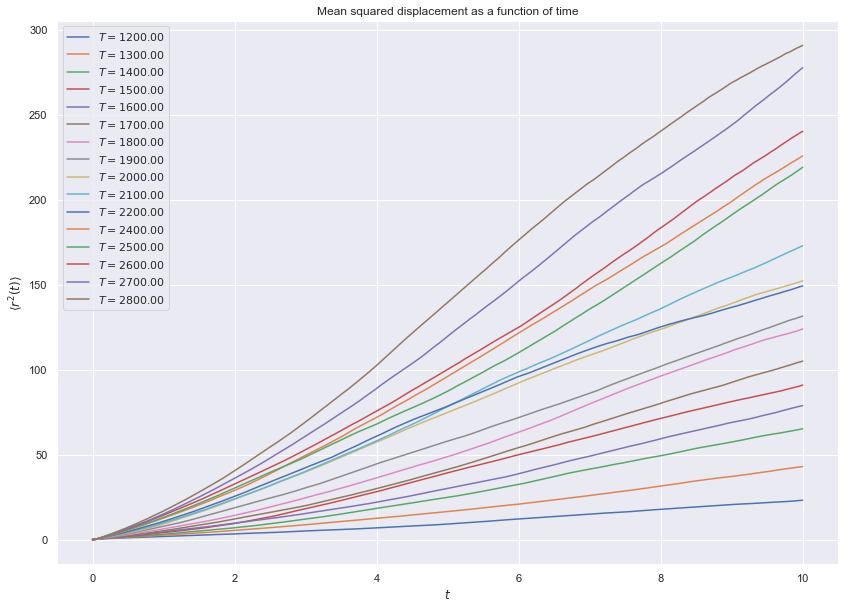

In [12]:
fig = plt.figure(figsize=(14, 10))

log_df_list = []

for T, filename in zip(temperature_list, file_list):
    log_df = pd.read_csv(filename, sep=r"\s+", skiprows=3, skipfooter=29, engine="python")
    log_df_list.append(log_df)
    plt.plot(
        log_df["v_time"],
        log_df["c_msd[4]"],
        label=fr"$T = {T:.2f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t)\rangle$")
plt.legend(loc="best")
plt.title(r"Mean squared displacement as a function of time")
plt.show()

In [13]:
t_t = 2.0

In [14]:
D_list = []
alpha_list = []

for T, log_df in zip(temperature_list, log_df_list):
    linear_df = log_df[log_df["v_time"] > t_t * 2]
    time = np.array(linear_df["v_time"])
    msd = np.array(linear_df["c_msd[4]"])
    
    clf = sklearn.linear_model.LinearRegression().fit(
        time[:, np.newaxis], msd[:, np.newaxis]
    )
    D_list.append(clf.coef_[0, 0] / 6)

    super_df = log_df[(log_df["v_time"] < t_t / 2) & (log_df["v_time"] > 0)]
    time = np.log(super_df["v_time"])
    msd = np.log(super_df["c_msd[4]"])

    clf = sklearn.linear_model.LinearRegression().fit(
        time[:, np.newaxis], msd[:, np.newaxis]
    )
    alpha_list.append(clf.coef_[0, 0])

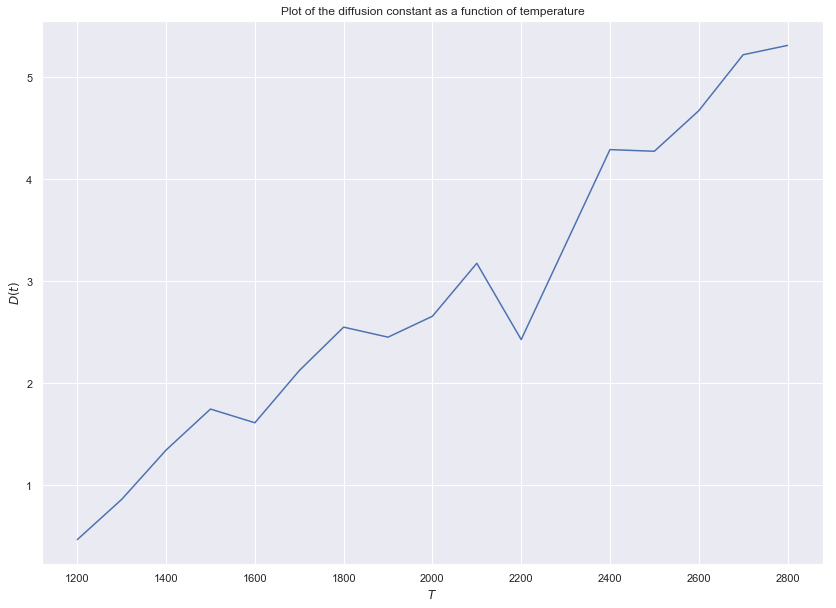

In [15]:
fig = plt.figure(figsize=(14, 10))

plt.plot(temperature_list, D_list)
plt.title(r"Plot of the diffusion constant as a function of temperature")
plt.xlabel(r"$T$")
plt.ylabel(r"$D(t)$")
plt.show()